In [1]:
import pandas as pd
import numpy as np
import NDCG as ndcg
import MHR as mhr
import sys
import types
ndcg.reload_package(mhr)
from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
%matplotlib inline

loading MHR


/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def pr_hs(r): 
    try:
        return ( 1 / r['pageRank'] ) + ( 1 / r['hits'] )
    except:
        return 0

def pr_len(r): 
    try:
        return ( 1 / r['pageRank'] ) + ( 1 / r['word_count'] )
    except:
        return 0
    
def hs_len(r): 
    try:
        return ( 1 / r['hits'] ) + ( 1 / r['word_count'] )
    except:
        return 0

def pr_hs_len(r): 
    try:
        return ( 1 / r['pr_hs'] ) + ( 1 / r['hs_len'] )
    except:
        return 0

def word_count(r): 
    try:
        return len(tokenizer.tokenize(r["reviewText"]))
    except:
        return 0

In [3]:
reviews_features = pd.read_csv('data/book_eletronic_sample_counts.csv.gz')
reviews_features = reviews_features[reviews_features.pageRank>0]
print (reviews_features.shape)
df_columns = reviews_features.select_dtypes(include=['float64','int','int64']).columns
df_columns

(24234, 32)


/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7,8,10,11,12,13,14,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1', u'Unnamed: 0.1.1',
       u'Unnamed: 0.1.1', u'Unnamed: 0.1.1.1', u'Unnamed: 0.1.1.1', u'overall',
       u'unixReviewTime', u'helpfulness', u'tot', u'pageRank', u'hits',
       u'powerWithStar', u'word_count', u'pr_hs', u'pr_len', u'hs_len',
       u'pr_hs_len', u'sentence_count', u'unigram_count', u'adj', u'noun',
       u'revRank'],
      dtype='object')

In [4]:
reviews_features['word_count']=reviews_features.apply(word_count,axis=1)
reviews_features['pr_hs']=reviews_features.apply(pr_hs,axis=1)
reviews_features['pr_len']=reviews_features.apply(pr_len,axis=1)
reviews_features['hs_len']=reviews_features.apply(hs_len,axis=1)
reviews_features['pr_hs_len']=reviews_features.apply(pr_hs_len,axis=1)
#reviews_features.to_csv('data/book_sample.csv.gz', compression='gzip')
reviews_features.shape

(24234, 32)

In [15]:
def helpf(x):
    x = str(x['helpful']) 
    try:
        pos = x.replace("[","").replace("]","").split(',')[0]
        neg = x.replace("[","").replace("]","").split(',')[1]
        tot = x.replace("[","").replace("]","").split(',')[1]
        return float ( float(pos) /  float(tot) )
    except:
        return 0

def tot(x): 
    x = str(x['helpful'])
    #print x.replace("[","").replace("]","").split(',')[1]
    try:
        return int(x.replace("[","").replace("]","").split(', ')[1])
    except:
        return 0



reviews_features['helpfulness']=reviews_features.apply(helpf,axis=1)
reviews_features['tot']=reviews_features.apply(tot,axis=1)

reviews_features,ndcg_mhr = mhr.executeFromDf(reviews_features)

product=0002051850 ndcg=0.783847313733 (0.783847313733)
product=000224053X ndcg=0.79024800371 (0.796648693688)
product=0006393195 ndcg=0.781925019086 (0.765279049838)
product=0006530702 ndcg=0.793045111192 (0.826405387509)
product=0007157150 ndcg=0.807210570282 (0.863872406645)
product=0007167040 ndcg=0.811961991584 (0.835719098093)
product=000721278X ndcg=0.829460077004 (0.934448589521)
product=0007228023 ndcg=0.839201502211 (0.907391478663)
product=0007231601 ndcg=0.843040112063 (0.873748990879)
product=000779021X ndcg=0.835347594209 (0.766114933521)
product=0026045702 ndcg=0.838421721959 (0.869162999453)
product=0029109752 ndcg=0.840663030498 (0.865317424427)
product=006000942X ndcg=0.837607778435 (0.800944753686)
product=0060083816 ndcg=0.834963852018 (0.800592808601)
product=0060084332 ndcg=0.836271296607 (0.854575520842)
product=0060175869 ndcg=0.838733676747 (0.87566937886)
product=0060192119 ndcg=0.831667379891 (0.718606630192)
product=006019491X ndcg=0.82002443708 (0.622094409

In [14]:
np.mean(ndcg_mhrs)

0.80716872550762186

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Library/Python/2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


pr_hs_len ndcg=0.77131406432
MHR ndcg=0.764850370217
RevRank ndcg=0.687225066461
461
461
461


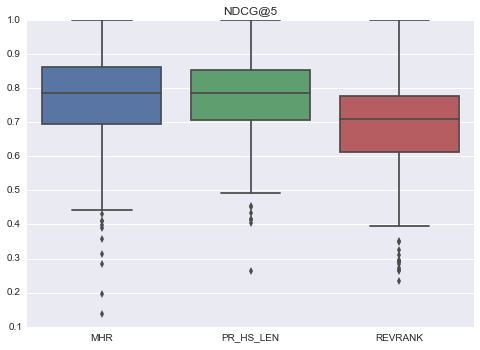

In [7]:
import seaborn as sns
k=5

ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',k) 
corr_pr_hs_len=ndcg.calc_corr(reviews_features,'pr_hs_len') 
print ("pr_hs_len ndcg="+str(np.mean(ndcg_pr_hs_len)))

#ndcg_mhr=ndcg.calc_ndcg(reviews_features,'powerWithStar',k) 
corr_mhr=ndcg.calc_corr(reviews_features,'powerWithStar') 
print ("MHR ndcg="+str(np.mean(ndcg_mhr)))

ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',k) 
corr_revRank=ndcg.calc_corr(reviews_features,'revRank') 
print ("RevRank ndcg="+str(np.mean(ndcg_revRank)))

print (len(ndcg_pr_hs_len))
print (len(ndcg_mhr))
print (len(ndcg_revRank))

tip={}
tip['PR_HS_LEN']=ndcg_pr_hs_len
tip['MHR']=ndcg_mhr
tip['REVRANK']=ndcg_revRank
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
#ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))

In [25]:
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',1) 
print ("pr_hs_len ndcg 1="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',3) 
print ("pr_hs_len ndcg 3="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',5) 
print ("pr_hs_len ndcg 5="+str(np.mean(ndcg_pr_hs_len)))

pr_hs_len ndcg 1=0.726896292723
pr_hs_len ndcg 3=0.756294836225
pr_hs_len ndcg 5=0.77131406432


In [26]:
ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',1) 
print ("revRank ndcg 1="+str(np.mean(ndcg_revRank)))
ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',3) 
print ("revRank ndcg 3="+str(np.mean(ndcg_revRank)))
ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',5) 
print ("revRank ndcg 5="+str(np.mean(ndcg_revRank)))

revRank ndcg 1=0.66052590951
revRank ndcg 3=0.681738097775
revRank ndcg 5=0.687225066461


In [27]:
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'powerWithStar',1) 
print ("MHR ndcg 1="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'powerWithStar',3) 
print ("MHR ndcg 3="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'powerWithStar',5) 
print ("MHR ndcg 5="+str(np.mean(ndcg_pr_hs_len)))

MHR ndcg 1=0.756376488673
MHR ndcg 3=0.758378765297
MHR ndcg 5=0.764850370217


[None, None, None, None, None, None, None, None, None, None, None, None]

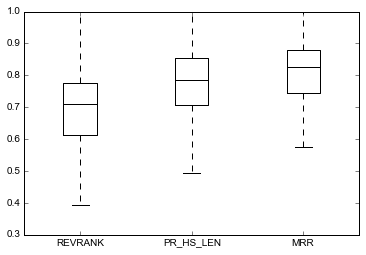

In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt 
%matplotlib inline
data_to_plot = [ndcg_revRank, ndcg_pr_hs_len, ndcg_mhr]


bp = plt.boxplot(data_to_plot, labels=["REVRANK","PR_HS_LEN","MRR"], sym='')
plt.setp(bp['boxes'], linewidth=1, color='black')
plt.setp(bp['fliers'], linewidth=1, color='black')
plt.setp(bp['medians'], linewidth=1, color='black')
plt.setp(bp['whiskers'], linewidth=1, color='black')